In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
cuda = torch.cuda.is_available()
import numpy as np
import collections
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from skimage import io


In [2]:
import torchvision
from PIL import Image

#981
train_size= 589
val_size= 196
test_size = 196

In [3]:
from torchvision import models

In [4]:
import csv

In [5]:
train_data_map = {}

In [6]:
val_data_map = {}

In [7]:
with open("training.csv", newline = '') as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    for row in reader:
        train_data_map[row[0]] = row[6]

In [8]:
with open("validation.csv", newline = '') as csvfile:
    reader = csv.reader(csvfile, delimiter = ',')
    for row in reader:
        val_data_map[row[0]] = row[6]

In [9]:
def parse_data(datadir, train_data_map, val_data_map):
    train_img_list = []
    val_img_list = []
    extensions = ["BMP", "JPEG", "JPG", "Jpeg", "PNG", "bmp", "jpeg", "jpg", "png", "tif"]
    for root, directories, filenames in os.walk(datadir): 
        for filename in filenames:
            extenstion = filename.split(".")[-1]
            if extenstion in extensions:  
                
                filei = os.path.join(root, filename)
                split_filename = filei.split("/")
                filename = split_filename[-2] + "/" + split_filename[-1]
                if filename in train_data_map:
                    train_img_list.append(filei)
                elif filename in val_data_map:
                    val_img_list.append(filei)
               
    return train_img_list, val_img_list

In [10]:
train_img_list, val_img_list = parse_data("../Manually_Annotated_Images_Part_08", train_data_map, val_data_map)

In [11]:
len(train_img_list)

152860

In [12]:
len(val_img_list)

2312

In [13]:
class ImageDataset(Dataset):
    def __init__(self, img_list, data_map):
        self.img_list = img_list
        self.data_map = data_map
        
        
    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, index):
        
        img_file = self.img_list[index]
        img = Image.open(img_file)
        img_h = 224
        img_w = 224
        img = torchvision.transforms.Resize((img_h,img_w))(img)
        img = torchvision.transforms.ToTensor()(img)
        split_filename = img_file.split("/")
        filename = split_filename[-2] + "/" + split_filename[-1]
        
        label = self.data_map[filename]
        return img, int(label)

In [14]:
train_data = ImageDataset(train_img_list, train_data_map)

In [15]:
len(train_data)

152860

In [16]:
train_dataset, val_dataset = torch.utils.data.random_split(train_data, (122288,30572))

In [17]:
# for file_name in train_data_map:
#     labels.add(train_data_map[file_name])

In [18]:
val_data = ImageDataset(val_img_list, val_data_map)

In [19]:
batch_size = 64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=8)




In [20]:
import logging
logging.basicConfig(filename="training_baseline_affectnet_part_8.log" ,
                            filemode="a+")
logger = logging.getLogger()
handler = logging.StreamHandler()
formatter = logging.Formatter('%(asctime)s %(name)-12s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)
logger.addHandler(handler)
logger.setLevel(logging.INFO)

In [21]:
class ConvBlock(nn.Module):
    def __init__(self, C_in, C_out, kernel_size, stride):
        super(ConvBlock, self).__init__()
        self.block = nn.Sequential(
                          nn.Conv2d(in_channels=C_in, out_channels=C_out, kernel_size=kernel_size, stride=stride),
                          nn.ReLU(),
                          nn.MaxPool2d(2))
        
    def forward(self, x):
        return self.block(x)
    
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class BaselineModel(nn.Module):
    def __init__(self, num_blocks):
        super(BaselineModel, self).__init__()
        layers = []
        num_classes = 11
        channels = [3, 64, 128, 256] # this needs to be modified according to num_blocks
        
        for i in range(num_blocks):
            layers.append(ConvBlock(C_in=channels[i], C_out=channels[i+1], kernel_size=5, stride=1))
        
        layers.append(nn.Dropout(p=0.25))
        
        layers.append(Flatten())
        
        layers.append(nn.Linear(256*24*24, 512))
        
        layers.append(nn.Dropout(p=0.5))
        
        layers.append(nn.Linear(512, num_classes))
        
        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)

In [22]:
model = BaselineModel(num_blocks=3)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
device = torch.device("cuda" if cuda else "cpu")
print(model)

BaselineModel(
  (net): Sequential(
    (0): ConvBlock(
      (block): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): ConvBlock(
      (block): Sequential(
        (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (2): ConvBlock(
      (block): Sequential(
        (0): Conv2d(128, 256, kernel_size=(5, 5), stride=(1, 1))
        (1): ReLU()
        (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (3): Dropout(p=0.25, inplace=False)
    (4): Flatten()
    (5): Linear(in_features=147456, out_features=512, bias=True)
    (6): Dropout(p=0.5, inplace=False)
    (7): Linear(in_features=512, out_features=11, bias=True)
  )
)


In [23]:
def train(model,n_epochs,train_dataloader, test_loader):
    model.train()
    model.to(device)
    train_losses = []
    eval_losses = []
    eval_accs = []
    for epoch in range(n_epochs):
        avg_loss = 0.0
        for batch_num, (feats, labels) in enumerate(train_dataloader):
            feats, labels = feats.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(feats)
            loss = criterion(outputs, labels.long())
            loss.backward()
            
            optimizer.step()
            
            avg_loss += loss.item()
            if batch_num % 50 == 49:
                logger.info('Epoch: {}\tBatch: {}\tAvg-Loss: {:.4f}'.format(epoch+1, batch_num+1, avg_loss/50))
 
                avg_loss = 0.0    
        
            torch.cuda.empty_cache()
            del feats
            del labels
            del loss
        train_loss, train_accuracy = test_classify_loss(model,train_dataloader)
        test_loss, test_accuracy = test_classify_loss(model,test_loader)
        eval_losses.append(test_loss)
        train_losses.append(train_loss)
        eval_accs.append(test_accuracy)
        logger.info('Epoch: {}\tTrain Loss: {}\tTrain Acc: {}\tTest-Loss: {}\tTest-acc: {:.4f}'.format(epoch+1, train_loss,train_accuracy, test_loss, test_accuracy))
    return train_losses, eval_losses, eval_accs

def test_classify_loss(model, test_loader):
    with torch.no_grad():
        model.eval()
        test_loss = []
        accuracies = 0
        total = 0
        for batch_num, (feats, labels) in enumerate(test_loader):
            feats, labels = feats.to(device), labels.to(device)
            outputs = model(feats)
            _, pred_labels = torch.max(F.softmax(outputs, dim=1), 1)
            pred_labels = pred_labels.view(-1)
            loss = criterion(outputs, labels.long())
            accuracies += float(torch.sum(torch.eq(pred_labels, labels)).item())
            total+=float(len(labels))
            test_loss.extend([loss.item()]*feats.size()[0])
            torch.cuda.empty_cache()
            del feats
            del labels
    model.train()
    return np.mean(test_loss), accuracies/total

In [ ]:
train_losses, eval_losses, eval_accs = train(model,5, train_dataloader, val_dataloader)

2019-11-27 01:03:56,753 root         INFO     Epoch: 1	Batch: 50	Avg-Loss: 1.0676
2019-11-27 01:04:05,812 root         INFO     Epoch: 1	Batch: 100	Avg-Loss: 1.0768
2019-11-27 01:04:14,876 root         INFO     Epoch: 1	Batch: 150	Avg-Loss: 1.0697
2019-11-27 01:04:23,932 root         INFO     Epoch: 1	Batch: 200	Avg-Loss: 1.0810
2019-11-27 01:04:33,050 root         INFO     Epoch: 1	Batch: 250	Avg-Loss: 1.1194
2019-11-27 01:04:42,152 root         INFO     Epoch: 1	Batch: 300	Avg-Loss: 1.0801
2019-11-27 01:04:51,220 root         INFO     Epoch: 1	Batch: 350	Avg-Loss: 1.1070
2019-11-27 01:05:00,334 root         INFO     Epoch: 1	Batch: 400	Avg-Loss: 1.0756
2019-11-27 01:05:09,354 root         INFO     Epoch: 1	Batch: 450	Avg-Loss: 1.1501
2019-11-27 01:05:18,328 root         INFO     Epoch: 1	Batch: 500	Avg-Loss: 1.1480
2019-11-27 01:05:27,368 root         INFO     Epoch: 1	Batch: 550	Avg-Loss: 1.1255
2019-11-27 01:05:36,447 root         INFO     Epoch: 1	Batch: 600	Avg-Loss: 1.0818
2019-

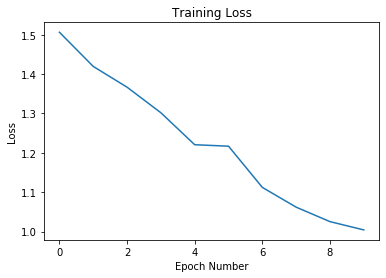

In [28]:
plt.title('Training Loss')
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.plot(train_losses)
plt.savefig("training_loss.png")

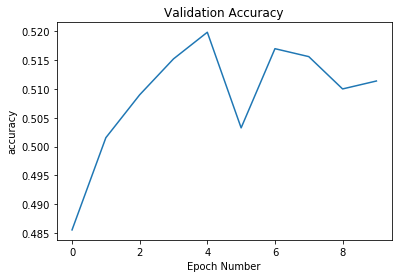

In [29]:
plt.title('Validation Accuracy')
plt.xlabel('Epoch Number')
plt.ylabel('accuracy')
plt.plot(eval_accs)
plt.savefig("val_acc.png")

In [27]:
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, 
                                               shuffle=False, num_workers=8)

NameError: name 'test_dataset' is not defined

In [ ]:
test_loss, test_accuracy = test_classify_loss(model, test_data_loader)

In [ ]:
test_loss, test_accuracy